In [ ]:
from pathlib import Path
import pandas as pd

from collections import OrderedDict
from pprint import pprint
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
root_dir = Path('~/data/rl-attention/full-scale').expanduser()

In [ ]:
def load_progress_log(experiment_dir: Path):
    return pd.read_csv(experiment_dir / 'logs' / 'progress.csv')

plog = load_progress_log(root_dir / 'MsPacmanNoFrameskip-v4,0,0.0,2019-06-13_18-50-37.845')
plog.head(n=10)

,approxkl,serial_timesteps,nupdates,explained_variance,clipfrac,time_elapsed,total_timesteps,policy_entropy,attention_loss,loss,fps,value_loss,policy_loss,ep_len_mean,ep_reward_mean
0,0.000004,128,1,0.000122,0.0,0.000004,1040,2.197221,7.782839,0.352018,243,0.748403,-0.000211,NaN,NaN
1,0.000042,256,2,0.000182,0.0,4.258237,2080,2.197120,7.782363,0.496132,512,1.037249,-0.000522,NaN,NaN
2,0.000180,384,3,0.000318,0.0,6.259999,3120,2.196503,7.782029,0.100610,507,0.248699,-0.001775,NaN,NaN
3,0.000197,512,4,0.001186,0.0,8.278165,4160,2.194827,7.782117,0.208685,439,0.461253,0.000007,445.166667,200.000000
4,0.000368,640,5,0.001083,0.0,10.609237,5200,2.192451,7.782027,0.289652,459,0.627406,-0.002127,445.166667,200.000000
5,0.000900,768,6,0.002331,0.0,12.841412,6240,2.185259,7.781937,0.207484,433,0.464589,-0.002958,502.875000,305.000000
6,0.000754,896,7,0.001283,0.0,15.207446,7280,2.173832,7.782009,0.223446,467,0.492772,-0.001202,483.200000,278.000000
7,0.000523,1024,8,0.000981,0.0,17.398204,8320,2.164759,7.782113,0.198598,442,0.441908,-0.000708,481.357143,270.714286
8,0.000313,1152,9,0.000967,0.0,19.712763,9360,2.157354,7.781668,0.221723,440,0.487180,-0.000293,475.500000,264.375000
9,0.000315,1280,10,0.001925,0.0,22.041588,10400,2.157423,7.781392,0.248246,447,0.542836,-0.001598,456.666667,244.444444


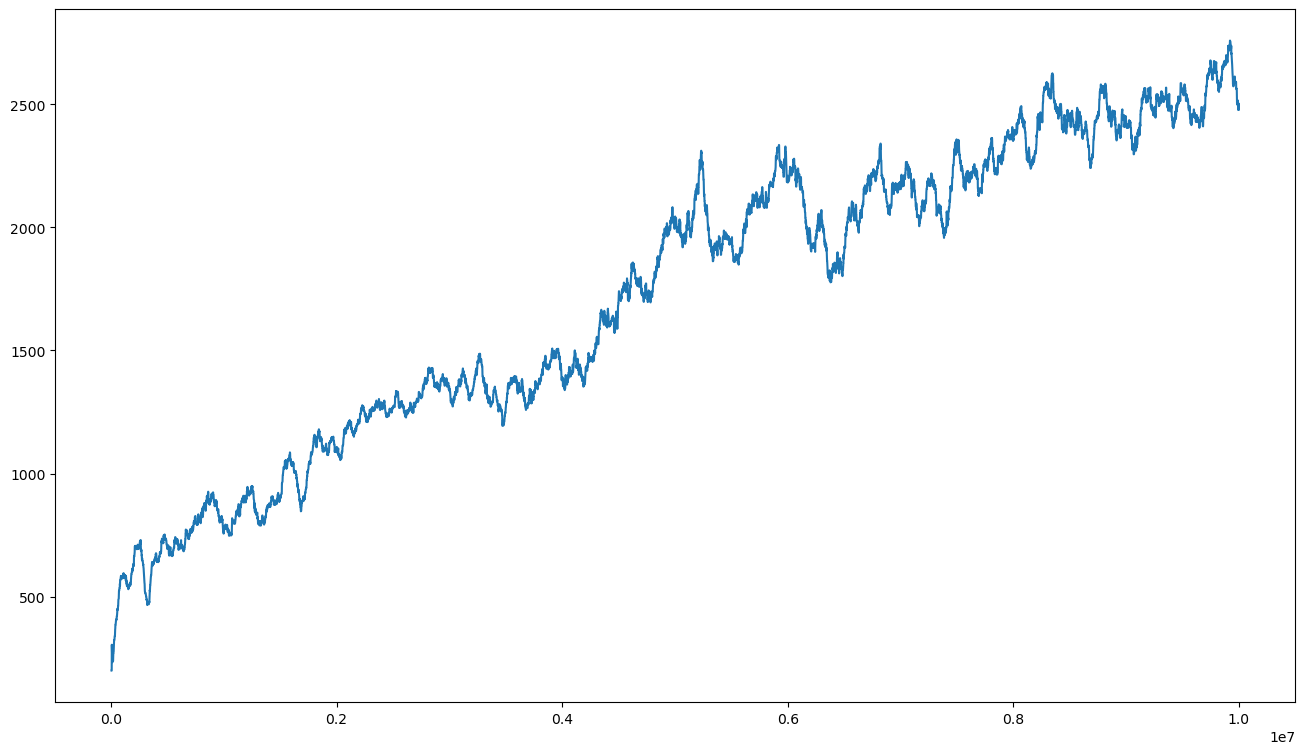

In [ ]:
plt.plot(plog.serial_timesteps * 8, plog.ep_reward_mean)

In [ ]:
def load_env_log(experiment_dir: Path):
    logs = []

    for i in range(8):
        log_env_path = (experiment_dir / 'logs' / f'{i}.monitor.csv')
        if not log_env_path.exists():
            print(f'{log_env_path} does not exist')
            continue
        log_env = pd.read_csv(log_env_path, skiprows=1).rename({
            'r': 'reward',
            'l': 'length',
            't': 'elapsed_time',
        }, axis=1)
        log_env['cumlength'] = log_env['length'].cumsum()
        log_env['env_index'] = i
        log_env['step_index'] = log_env['cumlength'] * 8 + log_env['env_index']
        logs.append(log_env)

    log = pd.concat(logs).sort_values('step_index')
    log.index.name = 'episode_index'
    log.reset_index(inplace=True)
    return log

elog = load_env_log(root_dir / 'MsPacmanNoFrameskip-v4,0,0.0,2019-06-13_18-50-37.845')
elog.head(n=10)

,episode_index,reward,length,elapsed_time,cumlength,env_index,step_index
0,0,200.0,412,15.045109,412,3,3299
1,0,150.0,431,15.323186,431,2,3450
2,0,140.0,445,15.460753,445,4,3564
3,0,260.0,450,15.657383,450,5,3605
4,0,200.0,458,15.742611,458,6,3670
5,0,250.0,475,15.938758,475,1,3801
6,0,640.0,674,19.786504,674,0,5392
7,0,600.0,678,19.829119,678,7,5431
8,1,150.0,393,21.944906,805,3,6443
9,1,190.0,416,22.586305,861,4,6892


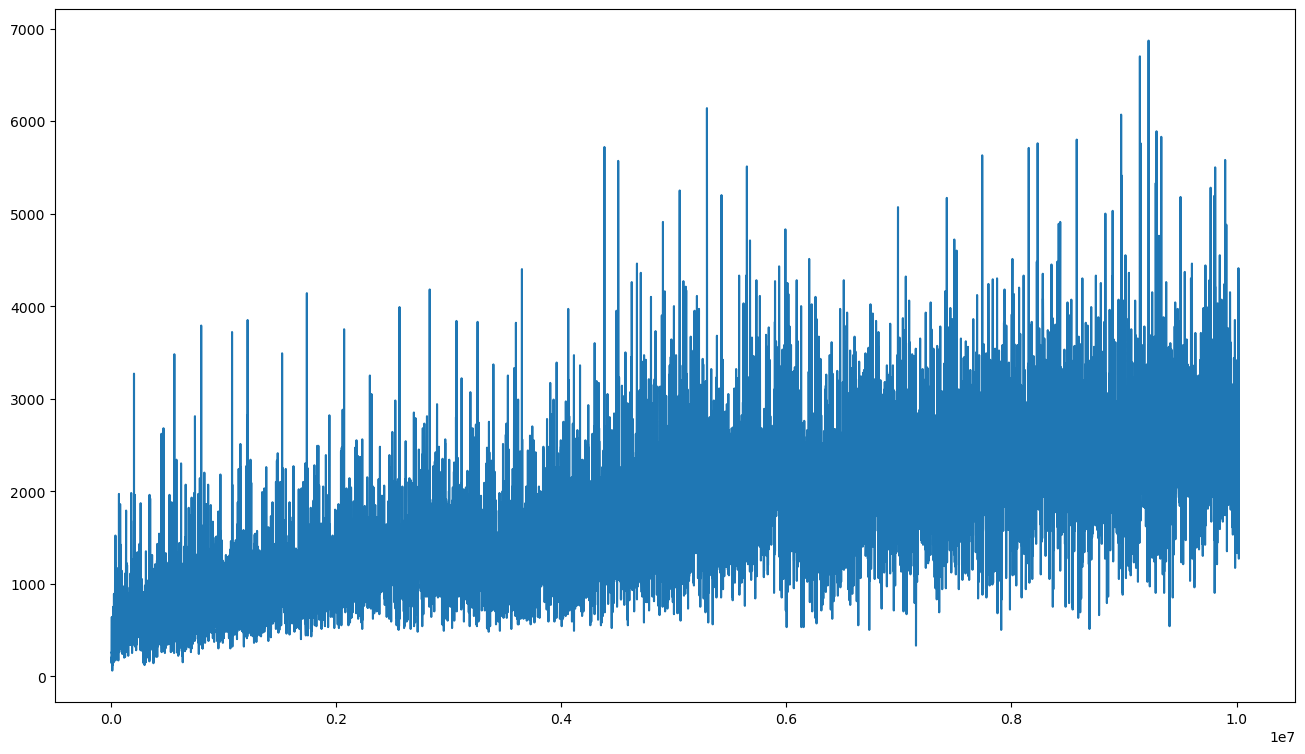

In [ ]:
plt.plot(elog.step_index, elog.reward)

In [ ]:
experiment_records = []

for experiment_path in root_dir.iterdir():
    with (experiment_path / 'config.json').open() as fp:
        cfg = json.load(fp)
    row = OrderedDict([
        (key, cfg[key])
        for key in [
            'time_steps',
            'env_name',
            'attn_coef',
            'train_seed',
        ]
    ])
    assert row['env_name'].endswith('NoFrameskip-v4')
    row['game'] = row['env_name'][:-len('NoFrameskip-v4')]
    row['name'] = experiment_path.name
    row['timestamp'] = pd.to_datetime(row['name'].split(',')[-1], format='%Y-%m-%d_%H-%M-%S.%f')
#     row['missing_envs'] = [
#         i for i in range(8)
#         if not (root_dir / row['name'] / 'logs' / f'{i}.monitor.csv').exists()
#     ]
    experiment_records.append(row)

df = pd.DataFrame.from_records(experiment_records).sort_values(
    ['time_steps', 'env_name', 'attn_coef', 'train_seed']
).reset_index(drop=True)
df.head(n=10)

,time_steps,env_name,attn_coef,train_seed,game,name,timestamp
0,10000000,BeamRiderNoFrameskip-v4,0.0000,0,BeamRider,"BeamRiderNoFrameskip-v4,0,0.0,2019-06-13_18-50...",2019-06-13 18:50:37.871
1,10000000,BeamRiderNoFrameskip-v4,0.0000,1,BeamRider,"BeamRiderNoFrameskip-v4,1,0.0,2019-06-15_06-11...",2019-06-15 06:11:18.092
2,10000000,BeamRiderNoFrameskip-v4,0.0000,2,BeamRider,"BeamRiderNoFrameskip-v4,2,0.0,2019-06-16_23-48...",2019-06-16 23:48:05.212
3,10000000,BeamRiderNoFrameskip-v4,0.0000,3,BeamRider,"BeamRiderNoFrameskip-v4,3,0.0,2019-06-23_20-00...",2019-06-23 20:00:56.530
4,10000000,BeamRiderNoFrameskip-v4,0.0000,4,BeamRider,"BeamRiderNoFrameskip-v4,4,0.0,2019-06-25_15-45...",2019-06-25 15:45:36.893
5,10000000,BeamRiderNoFrameskip-v4,0.0005,0,BeamRider,"BeamRiderNoFrameskip-v4,0,0.0005,2019-06-14_00...",2019-06-14 00:49:23.711
6,10000000,BeamRiderNoFrameskip-v4,0.0005,1,BeamRider,"BeamRiderNoFrameskip-v4,1,0.0005,2019-06-15_12...",2019-06-15 12:09:02.842
7,10000000,BeamRiderNoFrameskip-v4,0.0005,2,BeamRider,"BeamRiderNoFrameskip-v4,2,0.0005,2019-06-17_03...",2019-06-17 03:29:15.848
8,10000000,BeamRiderNoFrameskip-v4,0.0005,3,BeamRider,"BeamRiderNoFrameskip-v4,3,0.0005,2019-06-24_02...",2019-06-24 02:06:11.701
9,10000000,BeamRiderNoFrameskip-v4,0.0005,4,BeamRider,"BeamRiderNoFrameskip-v4,4,0.0005,2019-06-25_21...",2019-06-25 21:58:01.687


In [ ]:
df.pivot_table(
    index='attn_coef',
    columns='game',
    values='train_seed',
    aggfunc=len,
)

game,BeamRider,Breakout,Enduro,Frostbite,MsPacman,Seaquest
attn_coef,,,,,,
0.0000,5,5,5,5,5,5
0.0005,5,5,5,5,5,5
0.0010,5,5,5,5,5,5
0.0020,5,5,5,5,5,5
0.0030,5,5,5,5,5,5
0.0050,5,5,5,5,5,5


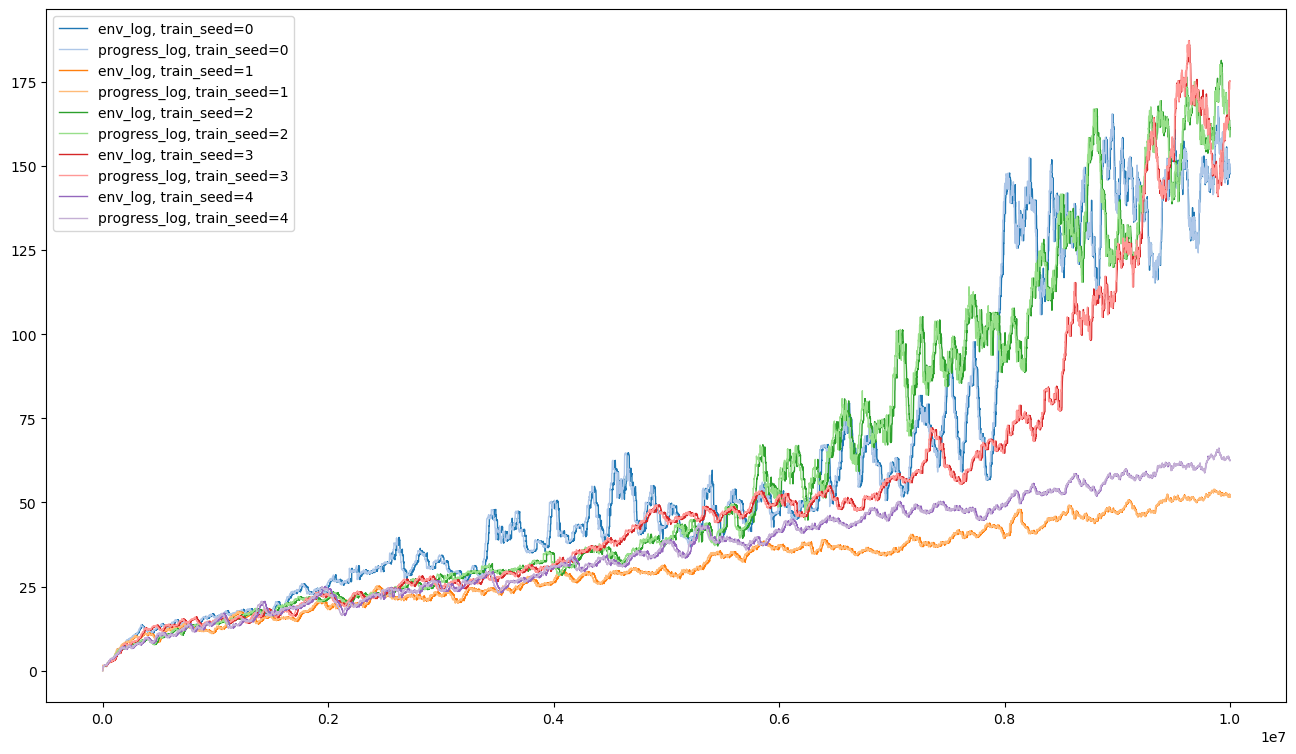

In [ ]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
tableau20 = [
    (r / 255, g / 255, b / 255)
    for (r, g, b) in tableau20
]

for i, row in enumerate(df[(df.game == 'Breakout') & (df.attn_coef == 0.0005)].itertuples()):
    elog = load_env_log(root_dir / row.name)
    sr = pd.Series(elog.reward.values, index=elog.step_index.values).rolling(100).mean()
    sr.index = sr.index / sr.index[-1] * 1e7
    sr.plot(
        label=f'env_log, train_seed={row.train_seed}',
        color=tableau20[2 * i],
        lw=1,
    )
    plog = load_progress_log(root_dir / row.name)
    plt.plot(
        plog.serial_timesteps * 8,
        plog.ep_reward_mean,
        label=f'progress_log, train_seed={row.train_seed}',
        color=tableau20[2 * i + 1],
        lw=1,
    )
    
plt.legend()

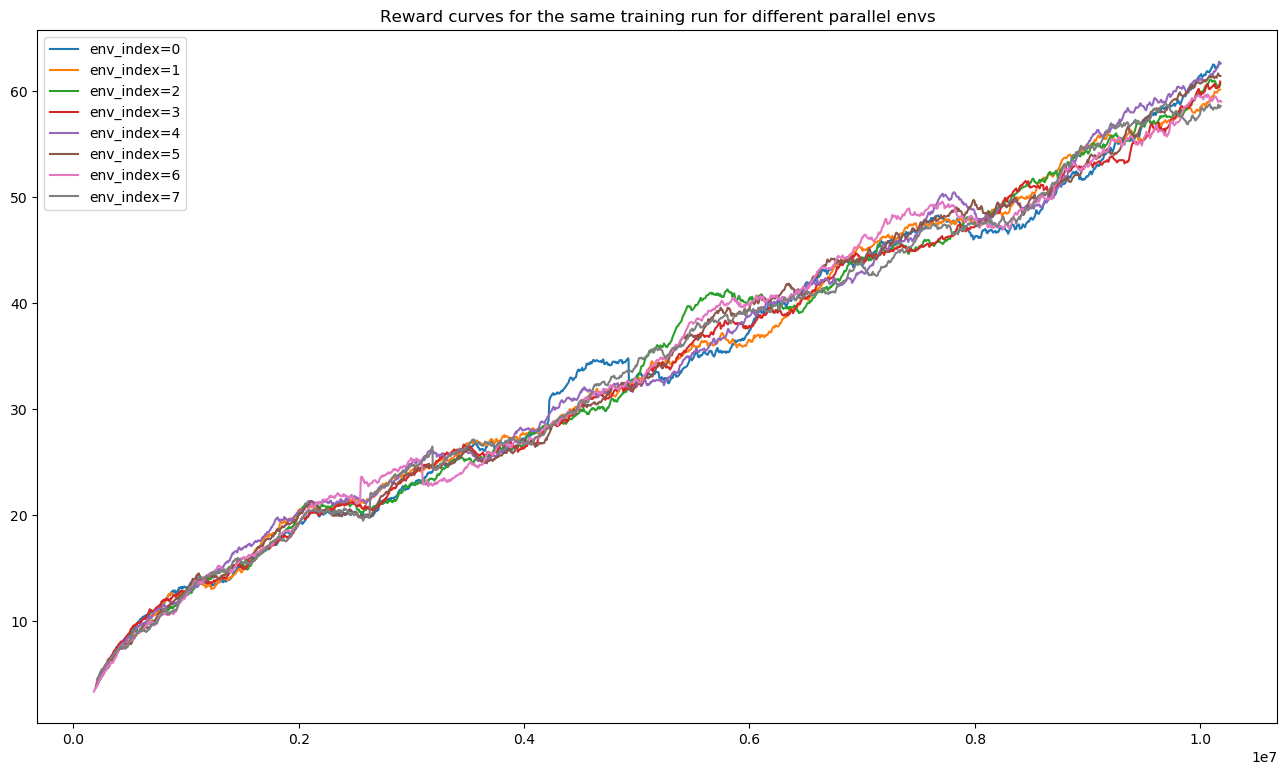

In [ ]:
for i, glog in elog.groupby('env_index'):
    pd.Series(glog.reward.values, index=(glog.cumlength * 8 + i).values).rolling(100).mean().plot(
        label=f'env_index={i}'
    )

plt.title('Reward curves for the same training run for different parallel envs')
plt.legend()

---

In [ ]:
import bisect

import numpy as np
import scipy as sp
import scipy.interpolate


def interpolate_series(sr, new_index):
    assert len(sr.values.shape) == 1
    assert len(new_index.shape) == 1
#     assert new_index[-1] <= sr.index[-1] < new_index[-1] + (new_index[-1] - new_index[-2])
    assert not sr.index.duplicated().any()
    
    spl = sp.interpolate.splrep(
        y=sr.values,
        x=sr.index,
        s=0,
        k=1,
    )
    new_values = sp.interpolate.splev(new_index, spl)
    
    return pd.Series(new_values, index=new_index)


def plot_averaged_curve(ax, srs, color, label=None, itrp_len=500):
    new_index_min = max(sr.index[0] for sr in srs)
    new_index_max = min(sr.index[-1] for sr in srs)
    new_index = np.linspace(new_index_min, new_index_max, itrp_len)
    itrp_srs = []
    for sr in srs:
#         itrp_index = new_index[:bisect.bisect_right(new_index, sr.index[-1])]
        isr = interpolate_series(sr, new_index)
        itrp_srs.append(isr)
    mean = []
    std = []
    vals = None
    for i in range(itrp_len):
        vals = [isr.iloc[i] for isr in itrp_srs if i < len(isr)]
        mean.append(np.mean(vals))
        std.append(np.std(vals))
    mean = np.array(mean)
    std = np.array(std)
    ax.plot(new_index, mean, color=color, alpha=0.7, label=label, lw=1)
    ax.fill_between(new_index, mean - std, mean + std, color=color, alpha=0.1, antialiased=True)
    return new_index, vals

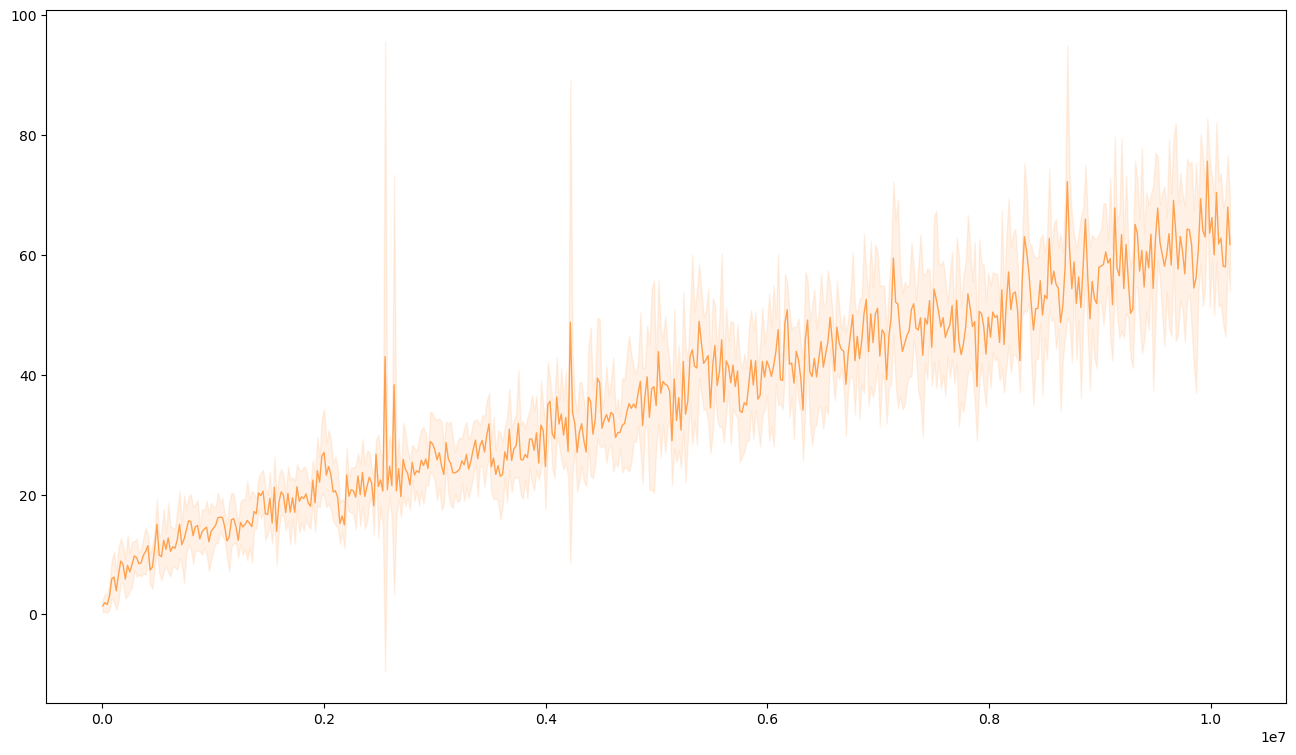

In [ ]:
_ = plot_averaged_curve(plt.gca(), [
    pd.Series(glog.reward.values, index=(glog.cumlength * 8).values)
    for i, glog in elog.groupby('env_index')
], 'C1')

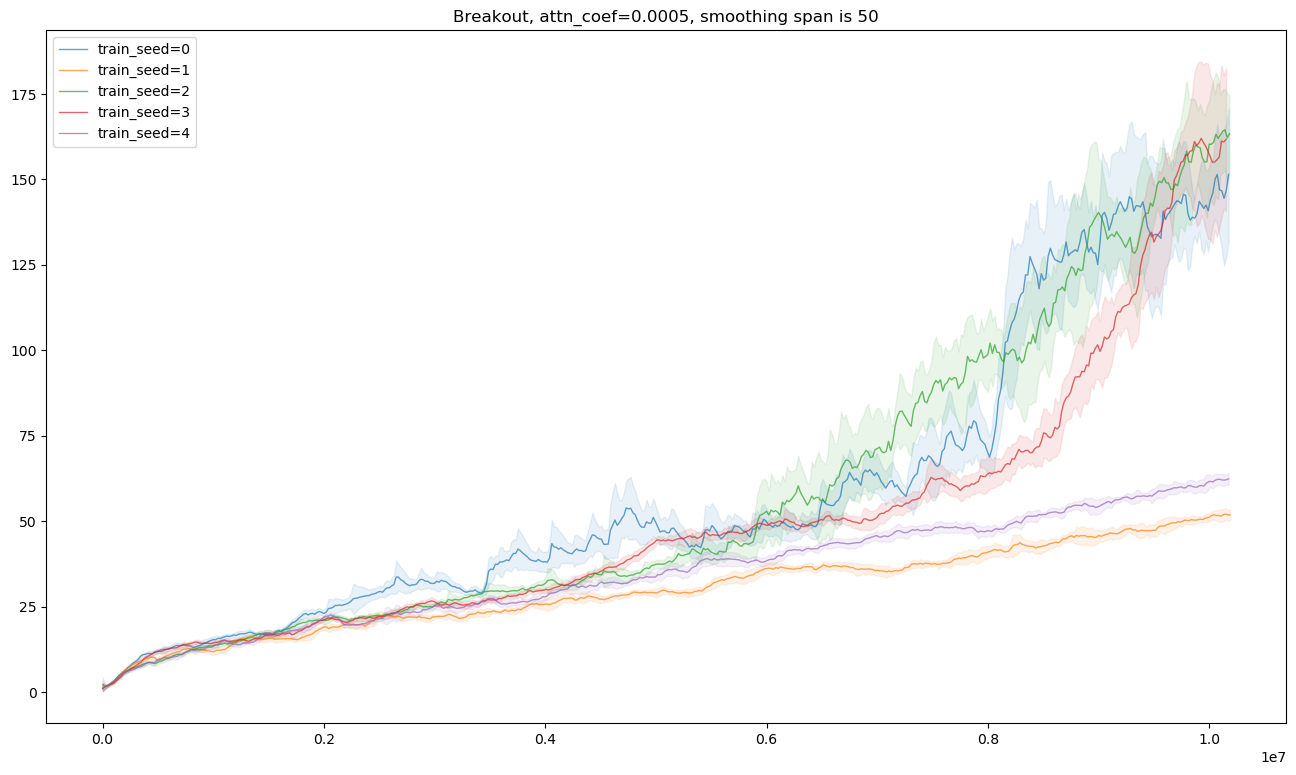

In [ ]:
for row in df[(df.game == 'Breakout') & (df.attn_coef == 0.0005)].itertuples():
    log = load_env_log(root_dir / row.name)
#     plt.plot(log.cumlength * 8, log.reward, label=f'train_seed={row.train_seed}')
#     pd.Series(log.reward.values, index=(log.cumlength * 8).values).ewm(span=300).mean().plot(
#         label=f'train_seed={row.train_seed}'
#     )
    _ = plot_averaged_curve(plt.gca(), [
        pd.Series(glog.reward.values, index=(glog.cumlength * 8).values).ewm(span=50).mean()
        for i, glog in log.groupby('env_index')
    ], f'C{row.train_seed}', label=f'train_seed={row.train_seed}')
    
plt.title('Breakout, attn_coef=0.0005, smoothing span is 50')
plt.legend()

In [ ]:
import matplotlib.cm as cm

all_coefs = sorted(df.attn_coef.unique())

coef_colors = {
    coef: cm.rainbow(i / (len(all_coefs) - 1)) #f'C{i}'
    for i, coef
    in enumerate(all_coefs)
}

all_games = [
    'BeamRider', 'Breakout',
    'MsPacman', 'Frostbite',
    'Enduro', 'Seaquest',
]

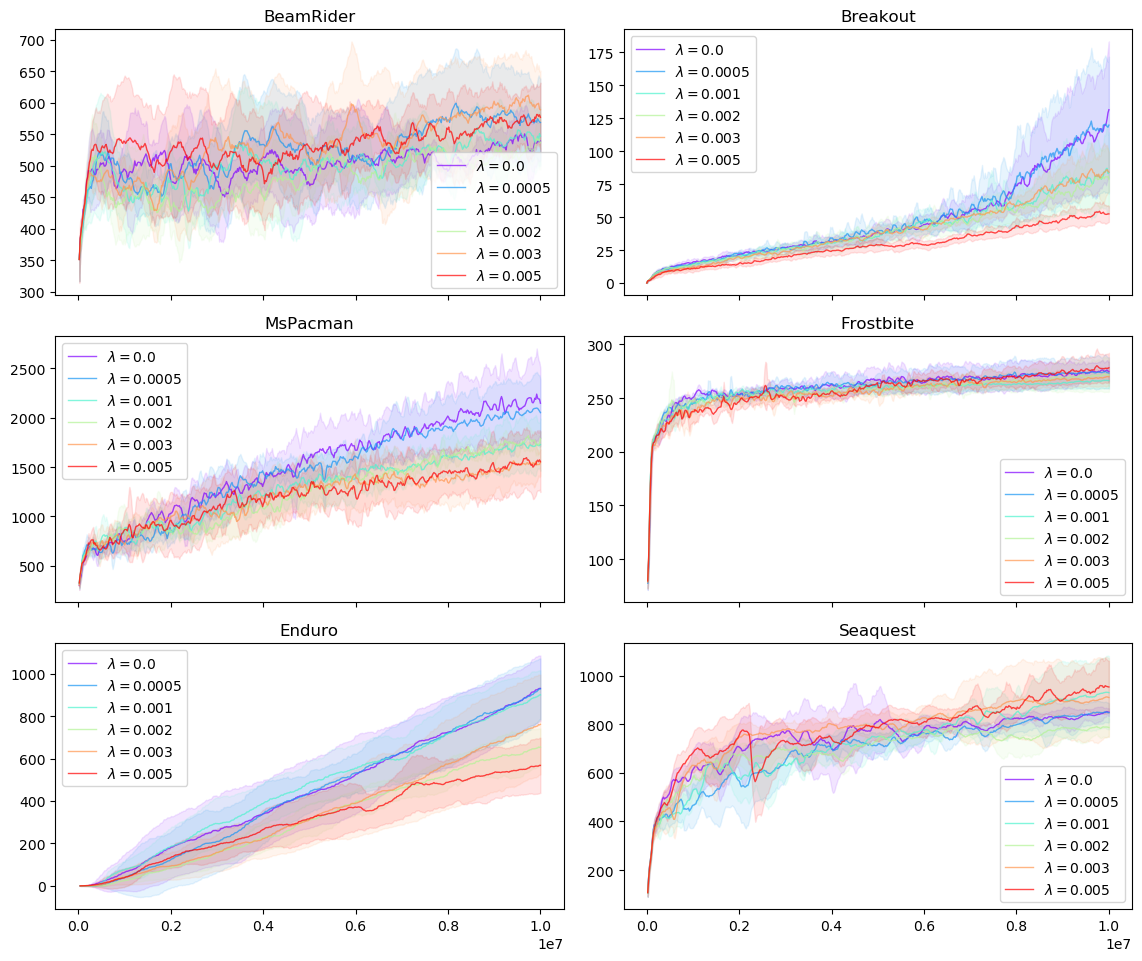

In [ ]:
from collections import OrderedDict

scale = 0.6
f, axarr = plt.subplots(nrows=3, ncols=2, figsize=(19.2 * scale, 16.2 * scale), sharex=True)

records = []

for k, game in enumerate(all_games):
    i, j = np.unravel_index(k, axarr.shape)
    ax = axarr[i, j]
    
    for attn_coef, ddf in df[df.game == game].groupby('attn_coef'):
        srs = []
        for row in ddf.itertuples():
            plog = load_progress_log(root_dir / row.name)
            sr = pd.Series(plog.ep_reward_mean.values, index=(plog.serial_timesteps * 8).values)
#             sr.index = sr.index / sr.index[-1] * 1e7
#             sr = sr.groupby(sr.index).mean()
#             sr = sr.rolling(100).mean()
            srs.append(sr)
        idx, final_vals = plot_averaged_curve(ax, srs, coef_colors[attn_coef], label=f'$\\lambda={attn_coef}$')
        records.append(OrderedDict([
            ('game', game),
            ('attn_coef', attn_coef),
            ('final_vals', final_vals),
        ]))

    ax.set_title(game)
    ax.legend()

f.tight_layout()
f.savefig('/tmp/scratch/rl_attention_reward_curves.pdf')
f.savefig('/tmp/scratch/rl_attention_reward_curves.png')

In [ ]:
df_results = pd.DataFrame.from_records(records)
df_results['mean_std'] = df_results.apply(
    lambda row: f'{np.mean(row["final_vals"]):.0f}±{np.std(row["final_vals"]):.0f}', axis=1
)
df_results = df_results.pivot(
    index='attn_coef',
    columns='game',
    values='mean_std',
)
df_results.index.name = None
df_results.columns.name = None
df_results.to_csv('/tmp/scratch/rl_attention_results.csv')
df_results

,BeamRider,Breakout,Enduro,Frostbite,MsPacman,Seaquest
0.0000,540±30,131±52,930±155,275±9,2147±354,851±15
0.0005,569±69,120±52,928±143,273±15,2052±336,849±39
0.0010,547±46,84±31,900±115,266±7,1727±266,931±151
0.0020,537±43,79±21,654±87,271±16,1787±72,787±36
0.0030,589±62,84±15,761±234,270±9,1546±134,911±162
0.0050,577±55,52±6,568±130,278±14,1554±308,954±108


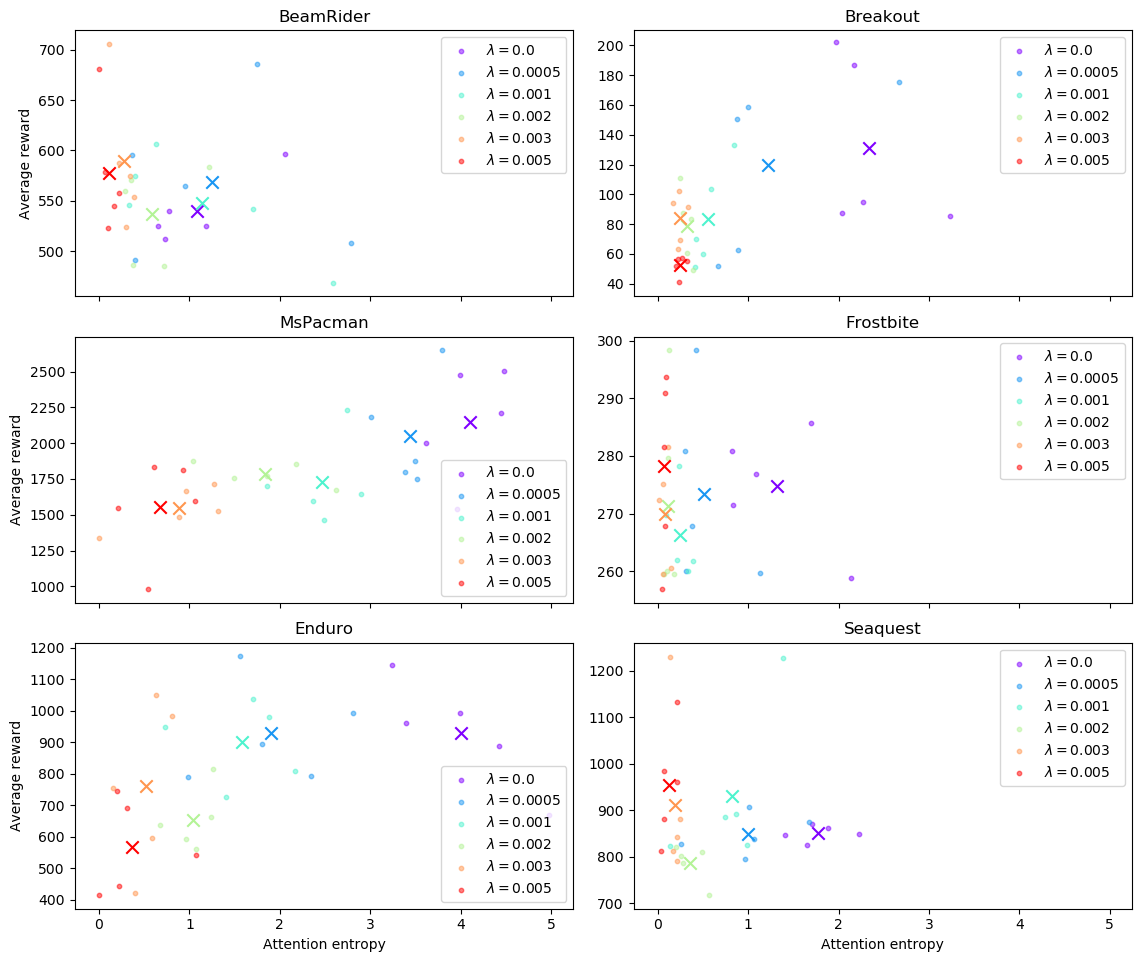

In [ ]:
scale = 0.6
f, axarr = plt.subplots(nrows=3, ncols=2, figsize=(19.2 * scale, 16.2 * scale), sharex=True)

for k, game in enumerate(all_games):
    i, j = np.unravel_index(k, axarr.shape)
    ax = axarr[i, j]
    
    for attn_coef, ddf in df[df.game == game].groupby('attn_coef'):
        xs = []
        ys = []
        for row in ddf.itertuples():
            plog = load_progress_log(root_dir / row.name)
            xs.append(plog.attention_loss.iloc[-1])
            ys.append(plog.ep_reward_mean.iloc[-1])
        ax.scatter(
            xs, ys,
            c=[coef_colors[attn_coef]],
            alpha=0.5,
            label=f'$\\lambda={attn_coef}$',
            s=10,
        )
        ax.scatter(
            np.mean(xs), np.mean(ys),
            c=[coef_colors[attn_coef]],
            marker='x',
            s=80,
        )

    ax.set_title(game)
    ax.legend()
    
    if i == axarr.shape[0] - 1:
        ax.set_xlabel('Attention entropy')
        
    if j == 0:
        ax.set_ylabel('Average reward')

f.tight_layout()
f.savefig('/tmp/scratch/rl_attention_final_scatterplots.pdf')
f.savefig('/tmp/scratch/rl_attention_final_scatterplots.png')